In [1]:
import os
import re
import sys
import time
import copy
import random
import argparse

from collections import OrderedDict

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter


import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision import datasets

import PIL

import matplotlib
from mpl_toolkits import mplot3d
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

import seaborn as sns

from livelossplot import PlotLosses

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import IncrementalPCA

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, classification_report

from tqdm import tqdm

sys.path.append("../src/expB/")
from spheres import RandomSphere
from ptcifar.models import *
from learn_mfld_distance import test
from myNNs import *

In [2]:



dataset_dir = "/azuredrive/datasets/expB/one_sphere"

dataset_files = [
    'r=0.5,max_norm=0.25,D=0.2,n=10,k=2,transformed,nearzero',
    'r=0.5,max_norm=0.25,D=0.2,n=100,k=2,transformed,nearzero',
    'r=0.5,max_norm=0.25,D=0.2,n=1000,k=2,transformed,nearzero',
    'r=0.5,max_norm=0.25,D=0.2,n=25,k=2,transformed,nearzero',
    'r=0.5,max_norm=0.25,D=0.2,n=250,k=2,transformed,nearzero',
    'r=0.5,max_norm=0.25,D=0.2,n=3,k=2,transformed,nearzero',
    'r=0.5,max_norm=0.25,D=0.2,n=5,k=2,transformed,nearzero',
    'r=0.5,max_norm=0.25,D=0.2,n=50,k=2,transformed,nearzero',
    'r=0.5,max_norm=0.25,D=0.2,n=500,k=2,transformed,nearzero',
    'r=0.5,max_norm=0.25,D=0.2,n=750,k=2,transformed,nearzero',
    'r=0.5,max_norm=0.25,D=0.2,n=1000,k=2,transformed,nearzero'
]


dump_dir = "/azuredrive/dumps/expB_learning_distance_from_mfld/vary_by_n_k=2/"

model_files = [os.path.join(dump_dir, i, j, "models") for i in os.listdir(dump_dir) for j in os.listdir(os.path.join(dump_dir, i))]
models_fn = sorted([sorted(os.listdir(i), key=lambda x: int(x.split("_")[-1].split(".")[0]))[-1] for i in model_files], key=lambda x: int(re.findall("n=[0-9]*", x)[0].strip(";").split("=")[1]))
models_fn = [os.path.join(dump_dir, re.findall(r'n=[0-9]*;', i)[0].strip(";"), j, "models", i) for i in models_fn for j in os.listdir(os.path.join(dump_dir, re.findall(r'n=[0-9]*;', i)[0].strip(";")))]

phase = "val" # whether to analyse on train, val or test

datasets_fn = sorted([os.path.join(dataset_dir, i, phase + "_set.pt") for i in dataset_files], key=lambda x: int(x.split(",")[3].split("=")[1]))






In [3]:
datasets_fn

['/azuredrive/datasets/expB/one_sphere/r=0.5,max_norm=0.25,D=0.2,n=3,k=2,transformed,nearzero/val_set.pt',
 '/azuredrive/datasets/expB/one_sphere/r=0.5,max_norm=0.25,D=0.2,n=5,k=2,transformed,nearzero/val_set.pt',
 '/azuredrive/datasets/expB/one_sphere/r=0.5,max_norm=0.25,D=0.2,n=10,k=2,transformed,nearzero/val_set.pt',
 '/azuredrive/datasets/expB/one_sphere/r=0.5,max_norm=0.25,D=0.2,n=25,k=2,transformed,nearzero/val_set.pt',
 '/azuredrive/datasets/expB/one_sphere/r=0.5,max_norm=0.25,D=0.2,n=50,k=2,transformed,nearzero/val_set.pt',
 '/azuredrive/datasets/expB/one_sphere/r=0.5,max_norm=0.25,D=0.2,n=100,k=2,transformed,nearzero/val_set.pt',
 '/azuredrive/datasets/expB/one_sphere/r=0.5,max_norm=0.25,D=0.2,n=250,k=2,transformed,nearzero/val_set.pt',
 '/azuredrive/datasets/expB/one_sphere/r=0.5,max_norm=0.25,D=0.2,n=500,k=2,transformed,nearzero/val_set.pt',
 '/azuredrive/datasets/expB/one_sphere/r=0.5,max_norm=0.25,D=0.2,n=750,k=2,transformed,nearzero/val_set.pt',
 '/azuredrive/datasets/exp

In [4]:
models_fn

['/azuredrive/dumps/expB_learning_distance_from_mfld/vary_by_n_k=2/n=3/14052021-164949/models/test_MLP_model{hidden_sizes=512x4,sigmoid_last}_data{spheres_in_unit_cube;clamped;with_transforms;k=2;n=3;nearzero}_14052021-164949_val_loss_7.676822804114636e-07_epoch_498.pth',
 '/azuredrive/dumps/expB_learning_distance_from_mfld/vary_by_n_k=2/n=4/13052021-121952/models/test_MLP_model{hidden_sizes=512x4,sigmoid_last}_data{spheres_in_unit_cube;clamped;with_transforms;k=2;n=4;nearzero}_13052021-121952_val_loss_1.0205980220234779e-05_epoch_496.pth',
 '/azuredrive/dumps/expB_learning_distance_from_mfld/vary_by_n_k=2/n=5/13052021-124835/models/test_MLP_model{hidden_sizes=512x4,sigmoid_last}_data{spheres_in_unit_cube;clamped;with_transforms;k=2;n=5;nearzero}_13052021-124835_val_loss_3.986024612459005e-05_epoch_493.pth',
 '/azuredrive/dumps/expB_learning_distance_from_mfld/vary_by_n_k=2/n=10/13052021-130145/models/test_MLP_model{hidden_sizes=512x4,sigmoid_last}_data{spheres_in_unit_cube;clamped;wit

MSE for the learned distances: 4.0397037e-05
MSE for the learned distances (on-manifold): 4.0397037e-05
MSE for the learned distances: 7.3328614e-05
MSE for the learned distances (on-manifold): 7.3328614e-05
MSE for the learned distances: 6.468708e-05
MSE for the learned distances (on-manifold): 6.468708e-05
MSE for the learned distances: 9.716465e-05
MSE for the learned distances (on-manifold): 9.716465e-05
MSE for the learned distances: 0.00018775323
MSE for the learned distances (on-manifold): 0.00018775323
MSE for the learned distances: 0.00023850559
MSE for the learned distances (on-manifold): 0.00023850559
MSE for the learned distances: 0.0012426014
MSE for the learned distances (on-manifold): 0.0012426014
MSE for the learned distances: 0.0057733497
MSE for the learned distances (on-manifold): 0.0057733497
MSE for the learned distances: 0.005716446
MSE for the learned distances (on-manifold): 0.005716446


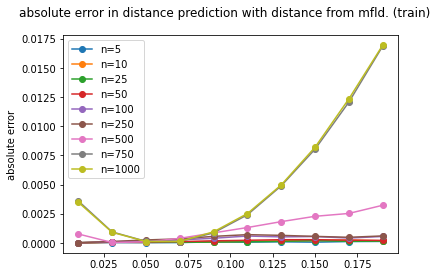

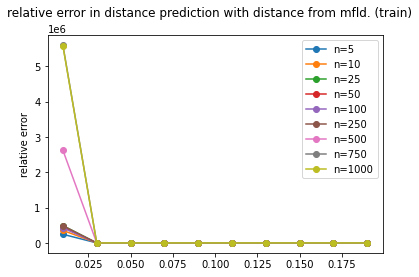

In [8]:
fig1 = plt.figure()
fig2 = plt.figure()

a = None
bins = None

for i, j in zip(datasets_fn[1:], models_fn[2:]):
    
#     plt.figure()
#     print(models_fn[i])
#     print(datasets_fn[i])
    device = torch.device("cuda:0")
    
    dataset = torch.load(i)
    dataloader = DataLoader(dataset, batch_size=512, shuffle=True, num_workers=8)
    
    model = MLP(input_size=dataset.points_n.shape[1], output_size=1, hidden_sizes=[512] * 4, use_relu=False, use_tanh=False)
    model.load_state_dict(torch.load(j)["model_state_dict"])
    
    mse, mse_on_mfld, all_distances, all_logits = test(model, dataloader, device)
    
    if bins is None:
        a = np.histogram(all_distances.numpy().reshape(-1))

        bins = a[1]

    logits = all_logits.numpy()
    distances = all_distances.numpy()
    rel_errors = [np.mean(np.abs(distances[(distances >= bins[i]) & (distances < bins[i+1])] - logits[(distances >= bins[i]) & (distances < bins[i+1])]) / (distances[(distances >= bins[i]) & (distances < bins[i+1])] + 1e-08)) for i in range(len(bins) - 1)]
    errors = [mean_squared_error(distances[(distances >= bins[i]) & (distances < bins[i+1])], logits[(distances >= bins[i]) & (distances < bins[i+1])], squared=True) for i in range(len(bins) - 1)]

#     xs = bins.reshape(-1, 1) + np.zeros((bins.shape[0], 30))
#     ys = np.arange(30).reshape(-1, 1) + np.zeros((30, bins.shape[0]))
#     fig, ax1 = fig1.subplots()
#     ax1.hist(all_distances.numpy().reshape(-1))
#     ax1.set_ylabel('frequency', color='b')
#     ax1.tick_params('y', colors='b')


#     ax2 = ax1.twinx()
    # s2 = np.sin(2 * np.pi * t)
    # ax2.hist(all_distances.numpy().reshape(-1))
    fig1.gca().plot([(bins[i] + bins[i+1]) /2 for i in range(len(bins) - 1)], errors, marker="o", label="n={size}".format(size=dataset.points_n.shape[1]))

#     fig1.set_ylabel('absolute error', color='k')
#     fig1.tick_params('y', colors='k')

    fig1.suptitle("absolute error in distance prediction with distance from mfld. (train)")
    # plt.plot(xs.T, ys, linestyle="dashed", color="k")
    # plt.hist(all_distances.numpy())
#     plt.show()
    
#     plt.figure()
    
#     xs = bins.reshape(-1, 1) + np.zeros((bins.shape[0], 30))
#     ys = np.arange(30).reshape(-1, 1) + np.zeros((30, bins.shape[0]))
#     fig, ax1 = fig2.subplots()
#     ax1.hist(all_distances.numpy().reshape(-1))
#     ax1.set_ylabel('frequency', color='b')
#     ax1.tick_params('y', colors='b')


#     ax2 = ax1.twinx()
#     # s2 = np.sin(2 * np.pi * t)
#     # ax2.hist(all_distances.numpy().reshape(-1))
    fig2.gca().plot([(bins[i] + bins[i+1]) /2 for i in range(len(bins) - 1)], rel_errors, marker="o", label="n={size}".format(size=dataset.points_n.shape[1]))


    fig2.suptitle("relative error in distance prediction with distance from mfld. (train)")
    # plt.plot(xs.T, ys, linestyle="dashed", color="k")
    # plt.hist(all_distances.numpy())
#     plt.show()

fig1.gca().set_ylabel('absolute error', color='k')
fig2.gca().set_ylabel('relative error', color='k')

fig1.gca().legend()
fig2.gca().legend()

In [6]:
fig1.show()

<AxesSubplot:>

In [17]:
sorted(os.listdir("/azuredrive/dumps/expB_learning_distance_from_mfld/vary_by_n_k=2/n=3/"), key=lambda x: int(x.split("_")[-1].split(".")[0]))[-1]

'test_MLP_model{hidden_sizes=512x4,sigmoid_last}_data{spheres_in_unit_cube;clamped;with_transforms;k=2;n=10;nearzero}_13052021-130145_val_loss_7.278684879565844e-05_epoch_487.pth'

In [20]:
ls "/azuredrive/dumps/expB_learning_distance_from_mfld/vary_by_n_k=2/n=5/"


13052021-124835/


In [25]:
import re

In [29]:
 'test_MLP_model{hidden_sizes=512x4,sigmoid_last}_data{spheres_in_unit_cube;clamped;with_transforms;k=2;n=10;nearzero}_13052021-130145_val_loss_7.278684879565844e-05_epoch_487.pth')




['n=10;']

In [ ]:
np.histogram()